# Ravichandran Ashwin Bayesian Average

Import the necessary libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
import warnings
warnings.filterwarnings('ignore')
import arviz

Will be scraping the data from ESPN Cricinfo's website

In [2]:
url = 'https://stats.espncricinfo.com/ci/engine/player/26421.html?class=1;template=results;type=bowling;view=innings'
r = requests.get(url)
r.ok

True

In [3]:
def player_list_dict_init():
    """Function returns a dictionary with the column names from the website"""
    player_list_dict = {'Overs':[],'Mdns':[],'Runs':[],'Wkts':[],'Econ':[],'Pos':[],'Inns':[],'Opp':[],'Ground':[],'Date':[],'#':[]}
    return player_list_dict

In [4]:
def player_df_init(url, **dictionary):
    """Function returns a dataframe of the scraped data. Takes in the url of the website and an empty dictionary"""
    r = requests.get(url)
    soup = BeautifulSoup(r.text, "html.parser")
    tables = soup.find_all('table',{'class':'engineTable'})
    table = tables[3]
    rows = table.find_all('tr')
    for col in rows:
        elements = col.find_all('td')
        if elements != []:
            dictionary['Overs'].append(elements[0].text.strip())
            dictionary['Mdns'].append(elements[1].text.strip())
            dictionary['Runs'].append(elements[2].text.strip())
            dictionary['Wkts'].append(elements[3].text.strip())
            dictionary['Econ'].append(elements[4].text.strip())
            dictionary['Pos'].append(elements[5].text.strip())
            dictionary['Inns'].append(elements[6].text.strip())
            dictionary['Opp'].append(elements[8].text.strip())
            dictionary['Ground'].append(elements[9].text.strip())
            dictionary['Date'].append(elements[10].text.strip())
            dictionary['#'].append(elements[11].text.strip())
    
    df = pd.DataFrame(dictionary)
    return df

Create an empty dictionary called bowl_dict where the values will be appended to

In [5]:
bowl_dict = player_list_dict_init() 

Initialising a Pandas Dataframe using the function

In [6]:
df = player_df_init(url, **bowl_dict)
df.head()

,Overs,Mdns,Runs,Wkts,Econ,Pos,Inns,Opp,Ground,Date,#
0,27.0,4,81,3,3.00,4,1,v West Indies,Delhi,6 Nov 2011,Test # 2015
1,21.3,5,47,6,2.18,2,3,v West Indies,Delhi,6 Nov 2011,Test # 2015
2,14.0,3,49,2,3.50,3,2,v West Indies,Eden Gardens,14 Nov 2011,Test # 2017
3,40.0,4,137,2,3.42,4,3,v West Indies,Eden Gardens,14 Nov 2011,Test # 2017
4,52.1,6,156,5,2.99,4,1,v West Indies,Wankhede,22 Nov 2011,Test # 2019


## Data Cleaning

Begin by extracting the necessary columns. Will also create an additional column based on the innings

In [7]:
df_rel = df[['Overs','Runs','Wkts']]
df_rel['Inns'] = df_rel.index + 1
df_rel.head()

,Overs,Runs,Wkts,Inns
0,27.0,81,3,1
1,21.3,47,6,2
2,14.0,49,2,3
3,40.0,137,2,4
4,52.1,156,5,5


Will now drop the rows where the player/ team didn't bowl or where the player was a sub and didn't bowl

In [8]:
#dropping rows where player DNB
row_drop1 = df_rel[df_rel['Overs'] == 'DNB'].index
df_rel = df_rel.drop(index = row_drop1, axis = 0)
#dropping rows where team didn't ball TDNB
row_drop2 = df_rel[df_rel['Overs'] == 'TDNB'].index
df_rel = df_rel.drop(index = row_drop2, axis = 0)
#dropping rows where player was sub
row_drop3 = df_rel[df_rel['Overs'] == 'sub'].index
df_drop = df_rel.drop(index = row_drop3, axis = 0)
df_drop.head()

,Overs,Runs,Wkts,Inns
0,27.0,81,3,1
1,21.3,47,6,2
2,14.0,49,2,3
3,40.0,137,2,4
4,52.1,156,5,5


Make the Runs and Wickets columns integer variables to allow further calculation. This means a running total can be calculated for the runs and wickets column

In [9]:
# converting Runs and Wkts to integer data type
df_drop['Runs'] = df_drop['Runs'].astype(int)
df_drop['Wkts'] = df_drop['Wkts'].astype(int)

# calculating the cumulative runs and wickets
df_drop['cum_run'] = df_drop['Runs'].cumsum()
df_drop['cum_wkt'] = df_drop['Wkts'].cumsum()

# calculating the rolling average and the average for the bowler in each match 
df_drop['ave_roll'] = df_drop['cum_run'] / df_drop['cum_wkt']
df_drop['ave_match'] = df_drop['Runs'] / df_drop['Wkts']

# selecting the necessary columns
stats = df_drop[['Runs','Wkts','Inns','cum_run','cum_wkt','ave_roll','ave_match']]

# drop the rows where the number of Wickets is 0
row_drop = stats[stats['Wkts'] == 0].index
stats = stats.drop(index = row_drop, axis = 0)
stats = stats.reset_index(drop = True)
stats.head()

,Runs,Wkts,Inns,cum_run,cum_wkt,ave_roll,ave_match
0,81,3,1,81,3,27.000000,27.000000
1,47,6,2,128,9,14.222222,7.833333
2,49,2,3,177,11,16.090909,24.500000
3,137,2,4,314,13,24.153846,68.500000
4,156,5,5,470,18,26.111111,31.200000


In [10]:
def ave_var(df, col_name):
    """Takes in a dataframe and the column name. It then outputs an array where the variance is calculated 
    from the 0th to i'th record"""
    size = len(df)
    var_arr = np.zeros(size)
    for i in range(size):
        var_arr[i] = np.var(df.loc[0:i,col_name])
    return var_arr

In [11]:
# calculating the variance for the ave_match column
stats['ave_var'] = ave_var(stats, 'ave_match')

In [12]:
stats.head()

,Runs,Wkts,Inns,cum_run,cum_wkt,ave_roll,ave_match,ave_var
0,81,3,1,81,3,27.000000,27.000000,0.000000
1,47,6,2,128,9,14.222222,7.833333,91.840278
2,49,2,3,177,11,16.090909,24.500000,72.376543
3,137,2,4,314,13,24.153846,68.500000,499.380208
4,156,5,5,470,18,26.111111,31.200000,399.596178


In [13]:
# calculating the standard error 
stats['std_err'] = (stats['ave_var'] / stats['Inns']) ** 0.5

In [14]:
# dropping the row where variance is 0 and resetting the index
var_0_index = stats[stats['ave_var'] == 0].index
stats_clean = stats.drop(index = var_0_index, axis = 0)
stats_clean = stats_clean.reset_index(drop = True)
stats_clean.head()

,Runs,Wkts,Inns,cum_run,cum_wkt,ave_roll,ave_match,ave_var,std_err
0,47,6,2,128,9,14.222222,7.833333,91.840278,6.776440
1,49,2,3,177,11,16.090909,24.500000,72.376543,4.911773
2,137,2,4,314,13,24.153846,68.500000,499.380208,11.173408
3,156,5,5,470,18,26.111111,31.200000,399.596178,8.939756
4,34,4,6,504,22,22.909091,8.500000,408.441358,8.250670


In [15]:
# defining the prior mean and standard deviation
prior_mean = 31.03
prior_std = 6.52

# defining the distribution size and and the prior distribution
dist_size = 100000
prior = np.random.normal(prior_mean, prior_std, size = dist_size)

# creating a likelihood dataframe l_df selecting relevant columns
l_df = stats_clean[['ave_var','ave_roll','std_err', 'Inns']]
size = len(l_df)

# creating an empty array to store the likelihood distribution 
l_array = np.zeros(shape = (size, dist_size))

# creating the posterior dictionary to store the mean and standard deviation
pos_dict_list = {'pos_mean':[],'pos_std':[]}

# creating an empty array to store the posterior distribution 
pos_array = np.zeros(shape = (size, dist_size))

In [16]:
# creating a for loop to iterate through and calculate the posterior distribution after each innings

for i in range(size):
#   assigning the i'th likelihood variance, innings, rolling average, and standard error
    l_var, l_n, l_avg, l_std_err = l_df.loc[i,'ave_var'], l_df.loc[i,'Inns'], l_df.loc[i,'ave_roll'], l_df.loc[i,'std_err']
    
#   calculating the i'th normal distribution
    l_array[i] = np.random.normal(l_avg, l_std_err, size = dist_size)
    
#   calculating and appending the posterior mean and posterior standard deviation
    pos_dict_list['pos_mean'].append(((prior_mean / (prior_std) ** 2) + ((l_n * l_avg) / l_var)) / (prior_std ** -2 + (l_n / l_var)))
    pos_dict_list['pos_std'].append((prior_std ** (-2) + (l_n / l_var)) ** (-0.5))
    
#   calculating the i'th posterior distribution
    pos_array[i] = np.random.normal(pos_dict_list['pos_mean'][i],pos_dict_list['pos_std'][i], size = dist_size)

In [17]:
# making the posterior dictionary a dataframe
pos_df = pd.DataFrame(pos_dict_list)

In [18]:
# concatenating the posterior dataframe the likelihood dataframe and some columns of the relevant statistics dataframe
df_concat = pd.concat([pos_df, l_df, stats_clean[['ave_match','Runs','Wkts']]], axis = 1) 
df_concat.head()

,pos_mean,pos_std,ave_var,ave_roll,std_err,Inns,ave_match,Runs,Wkts
0,22.950152,4.698379,91.840278,14.222222,6.776440,2,7.833333,47,6
1,21.499603,3.923121,72.376543,16.090909,4.911773,3,24.500000,49,2
2,29.283370,5.631361,499.380208,24.153846,11.173408,4,68.500000,137,2
3,29.322048,5.267808,399.596178,26.111111,8.939756,5,31.200000,156,5
4,27.908181,5.115531,408.441358,22.909091,8.250670,6,8.500000,34,4


In [19]:
from matplotlib import animation
%matplotlib qt

In [20]:
# plots an animation of the prior likelihood posterior 
fig, ax1 = plt.subplots(1,1, figsize = (10,112))


def animate(i):
    ax1.cla()
    ax1.set_xlim([0,50])
    ax1.set_xlabel("Bowling Average")
    ax1.set_ylabel("Relative Probability")
    sns.kdeplot(l_array[i], label = 'Likelihood', shade = True, ax = ax1)
    sns.kdeplot(pos_array[i], label = 'Posterior', shade = True, ax = ax1)
    sns.kdeplot(prior, label = 'Prior', shade = True, ax = ax1)
    ax1.set(title = "Innings: " +str(df_concat.loc[i,"Inns"]))
    ax1.legend(["Likelihood","Posterior","Prior"])
    
anim = animation.FuncAnimation(fig, animate, frames = len(l_array), interval = 500)

plt.show()

In [21]:
# using arviz to calculate the 90% probability
hpd = arviz.hdi(pos_array[-1], hdi_prob = 0.9)
hpd

array([21.09923978, 27.4412008 ])

<AxesSubplot:title={'center':'x'}>

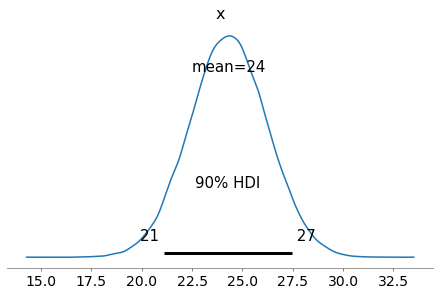

In [22]:
# plotting the posterior distributions
%matplotlib inline
arviz.plot_posterior(pos_array[-1], hdi_prob = 0.9)

In [23]:
print("There is a 90% probability that Ravi Ashwin's average exists within {:.2f} and {:.2f}. This results in a bayesian average of {:.2f} with a standard error of {:.2f}"\
     .format(round(hpd[0],2),round(hpd[1],2),round(pos_df['pos_mean'].iloc[-1],2), round(pos_df['pos_std'].iloc[-1],2)))

There is a 90% probability that Ravi Ashwin's average exists within 21.10 and 27.44. This results in a bayesian average of 24.30 with a standard error of 1.93


Based on these statistics we can say that Ashwin is a world class bowler. He does have a slightly higher standard error but even on the low end he is much better than the average bowler. However, being a spinner from the subcontinent means that he benefits from favourable conditions more often than not and if he played in SENA countries perhaps we would see a slightly higher average. Despite this Ravi Ashwin will likely end his career as a modern day great. 